# Feature Engineering Analysis

## Approach 1: Normalized Position in Sentence

We define:

\[ \text{pos_norm} = \frac{\text{vertex}}{n} \]

where `vertex` is the node’s index and `n` is the sentence length.  We expect roots to cluster near the middle of the sentence.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

In [3]:
df = pd.read_csv('../../data/expanded_train.csv')

In [4]:
# Compute normalized position
df['pos_norm'] = df['vertex'] / df['n']

In [5]:
df[['language','sentence','vertex','n','pos_norm','is_root']].head()

,language,sentence,vertex,n,pos_norm,is_root
0,Japanese,2,6,23,0.260870,0
1,Japanese,2,4,23,0.173913,0
2,Japanese,2,2,23,0.086957,0
3,Japanese,2,23,23,1.000000,0
4,Japanese,2,20,23,0.869565,0


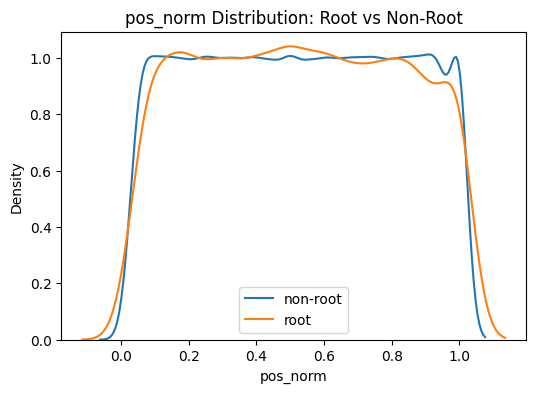

In [8]:
# Distribution of pos_norm: Root vs Non‐Root
plt.figure(figsize=(6,4))
sns.kdeplot(df[df['is_root']==0]['pos_norm'], label='non-root')
sns.kdeplot(df[df['is_root']==1]['pos_norm'], label='root')
plt.title('pos_norm Distribution: Root vs Non-Root')
plt.xlabel('pos_norm')
plt.ylabel('Density')
plt.legend()
plt.show()

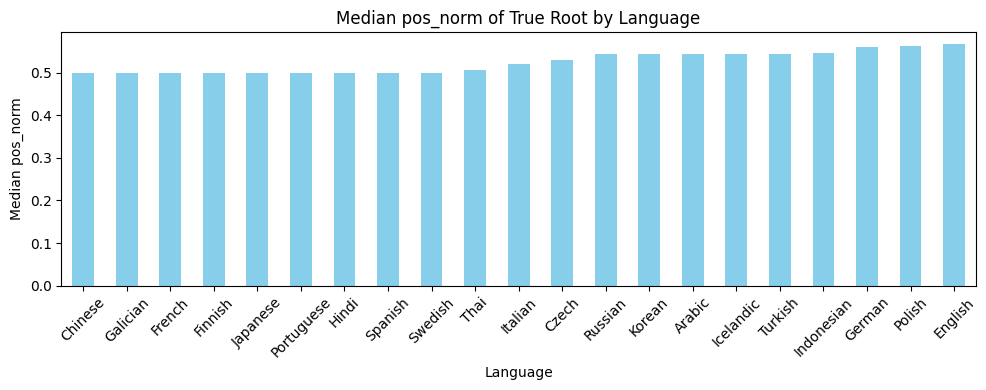

In [10]:
# Median Root Position by Language
lang_pos = (
    df[df['is_root']==1]
    .groupby('language')['pos_norm']
    .median()
    .sort_values()
)

plt.figure(figsize=(10,4))
lang_pos.plot(kind='bar', color='skyblue')
plt.title('Median pos_norm of True Root by Language')
plt.ylabel('Median pos_norm')
plt.xlabel('Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

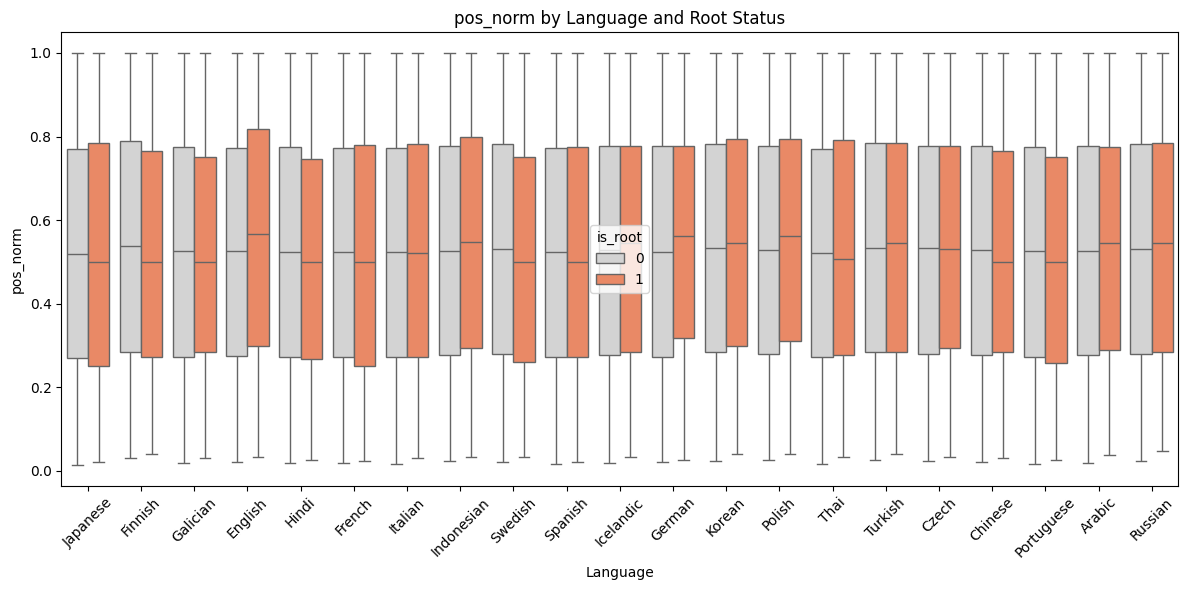

In [11]:
# Boxplot: pos_norm for Roots vs Non‐Roots Across Languages
plt.figure(figsize=(12,6))
sns.boxplot(x='language', y='pos_norm', hue='is_root', data=df, palette=['lightgray','coral'])
plt.title('pos_norm by Language and Root Status')
plt.ylabel('pos_norm')
plt.xlabel('Language')
plt.xticks(rotation=45)
plt.legend(title='is_root')
plt.tight_layout()
plt.show()

In [13]:
# Point‐Biserial Correlations
# Compute correlation across entire dataset
corr, pval = pointbiserialr(df['is_root'], df['pos_norm'])
print(f"Point‐biserial corr between is_root and pos_norm: r = {corr:.3f}, p = {pval:.3e}")

# Compute per‐language correlations
lang_corr = []
for lang, grp in df.groupby('language'):
    r, p = pointbiserialr(grp['is_root'], grp['pos_norm'])
    lang_corr.append({'language': lang, 'r': r, 'p': p})
lang_corr = pd.DataFrame(lang_corr).set_index('language').sort_values('r')

print("Per-language correlations:")
print(lang_corr)

Point‐biserial corr between is_root and pos_norm: r = 0.002, p = 2.998e-01
Per-language correlations:
                   r         p
language                      
Finnish    -0.014795  0.222981
Swedish    -0.014363  0.182238
Portuguese -0.008928  0.360670
Hindi      -0.006698  0.484141
Galician   -0.006522  0.501637
French     -0.004776  0.613469
Spanish    -0.004618  0.634563
Chinese    -0.002031  0.844827
Japanese    0.001037  0.906263
Italian     0.001188  0.901560
Czech       0.001589  0.886606
Thai        0.002627  0.782357
Icelandic   0.003403  0.755473
Korean      0.005365  0.640644
Arabic      0.006940  0.504662
Russian     0.007324  0.506623
Turkish     0.008486  0.465105
German      0.014668  0.155424
Polish      0.014855  0.186478
English     0.016940  0.100266
Indonesian  0.018631  0.084499


## Approach 2: Subtree‐Balance Metrics

We compute for each node:
1. `max_branch_size`: the size of the largest component when cutting each incident edge.
2. `subtree_entropy`: entropy over branch‐size fractions.

In [18]:
import networkx as nx
from math import log
import ast

In [19]:
train = pd.read_csv('../../data/train.csv')
train['edgelist'] = train['edgelist'].apply(ast.literal_eval)

In [20]:
# Merge edgelist into df
df2 = df.merge(
    train[['language','sentence','edgelist']],
    on=['language','sentence'],
    how='left'
)

In [24]:
# Compute subtree‐balance features
def compute_balance(group):
    edges = group['edgelist'].iloc[0]
    T = nx.Graph(edges)
    n = T.number_of_nodes()
    rows = []
    for v in T.nodes():
        sizes = []
        for nbr in T.neighbors(v):
            G2 = T.copy()
            G2.remove_edge(v, nbr)
            for comp in nx.connected_components(G2):
                if nbr in comp:
                    sizes.append(len(comp))
                    break
        max_branch = max(sizes) if sizes else 0
        ent = 0.0
        for s in sizes:
            p = s / n
            ent -= p * log(p, 2) if p > 0 else 0
        rows.append({'max_branch_size': max_branch, 'subtree_entropy': ent})
    # Build DataFrame: one row per node in same order as group
    df_bal = pd.DataFrame(rows)
    return df_bal

bal = (
    df2.groupby(['language','sentence'], group_keys=False)
       .apply(compute_balance)
       .reset_index(drop=True)
)


C:\Users\Kristof\AppData\Local\Temp\ipykernel_10320\3258586233.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_balance)


In [25]:
# Attach back
df_balance = pd.concat([df2.reset_index(drop=True), bal], axis=1)

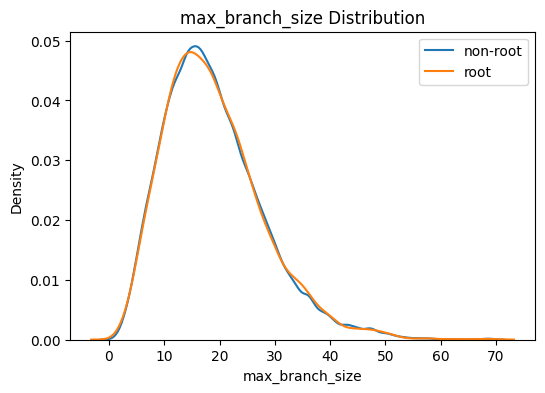

In [26]:
# Density of max_branch_size
plt.figure(figsize=(6,4))
sns.kdeplot(df_balance[df_balance.is_root==0]['max_branch_size'], label='non-root')
sns.kdeplot(df_balance[df_balance.is_root==1]['max_branch_size'], label='root')
plt.title('max_branch_size Distribution')
plt.xlabel('max_branch_size')
plt.legend()
plt.show()

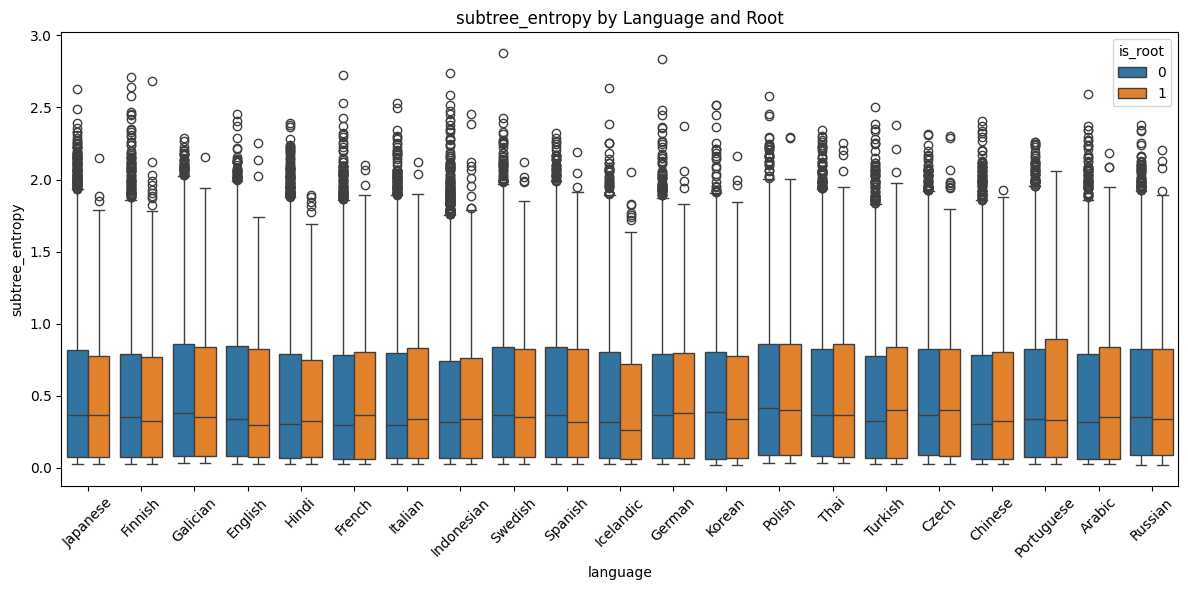

In [28]:
 # Boxplot of subtree_entropy by Language & Root
plt.figure(figsize=(12,6))
sns.boxplot(x='language', y='subtree_entropy', hue='is_root', data=df_balance)
plt.title('subtree_entropy by Language and Root')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Univariate Sentence‐Level Scoring on max_branch_size
# Trivial rule: predict root = node with smallest max_branch_size
scores = []
for (lang, sent), grp in df_balance.groupby(['language','sentence']):
    true_root = grp[grp.is_root==1].vertex.values[0]
    pred = grp.loc[grp.max_branch_size.idxmin(), 'vertex']
    scores.append(int(pred==true_root))
print('Root‐accuracy using min max_branch_size:', sum(scores)/len(scores))
# If this simple rule beats random (>~1/n) by a margin, subtree‐balance is promising, as we can see, it is not the case here as it only improves it a little

Root‐accuracy using min max_branch_size: 0.08838095238095238
